# Compression Artifacts

In [ ]:


# RAW_VIDEO = "./X0.mp4"   # Raw video
# COMPRESSED_VIDEO = "./video_compressed.mp4"

# FRAMES_RAW = "./video_raw"
# FRAMES_COMP = "./video_compressed"

# MASK_OUTPUT_RAW = "./results/mask_raw"
# MASK_OUTPUT_COMP = "./results/mask_compressed"

# MASK_MODEL = "../Video_Decaptioning/mask_extraction/checkpoint/MaskExtractor.pth"  # Model params

# for d in [os.path.dirname(COMPRESSED_VIDEO), FRAMES_RAW, FRAMES_COMP, MASK_OUTPUT_RAW, MASK_OUTPUT_COMP]:
#     os.makedirs(d, exist_ok=True)

# print("All directories created!")


## Distortion

Add compression distortion to the original videos.

In [ ]:
# # Raw video sliced
# !ffmpeg -y -i $RAW_VIDEO $FRAMES_RAW/%03d.png

# # Compression
# !ffmpeg -y -i $RAW_VIDEO -c:v libx264 -preset veryfast -crf 35 -c:a copy $COMPRESSED_VIDEO

# # Compressed video sliced
# !ffmpeg -y -i $COMPRESSED_VIDEO $FRAMES_COMP/%03d.png

In [ ]:
import os

print(os.getcwd())
print(os.listdir("."))

import sys
print(sys.executable)

In [1]:
import os
import sys
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from bm3d import bm3d, BM3DProfile
from tqdm import tqdm
import matplotlib.pyplot as plt

# -------------------------------
# User settings
# -------------------------------
INPUT_FOLDER = "../dataset/train/X"         # folder containing raw .mp4
OUTPUT_RAW_FRAMES = "./frame_raw"
OUTPUT_COMPRESSED_FRAMES = "./frame_compressed"
OUTPUT_COMPRESSED_VIDEOS = "./video_compressed"
FRAMES_DEBLOCK = "./frame_deblock"
FRAMES_BM3D = "./frame_bm3d"
# FRAMES_COMBO = "./frame_combo"

MASK_ORIG = "mask_orig"
MASK_COMP = "mask_comp"
MASK_DEBLOCK = "mask_deblock"
MASK_BM3D = "mask_bm3d"
# MASK_COMBO = "mask_combo"

N_VIDEOS = 200   # number of videos to process

CRF = 35        # compression strength (lower = better quality)

# -------------------------------
# Create output dirs if missing
# -------------------------------
os.makedirs(OUTPUT_RAW_FRAMES, exist_ok=True)
os.makedirs(OUTPUT_COMPRESSED_FRAMES, exist_ok=True)
os.makedirs(OUTPUT_COMPRESSED_VIDEOS, exist_ok=True)
os.makedirs(FRAMES_DEBLOCK, exist_ok=True)
os.makedirs(FRAMES_BM3D, exist_ok=True)
# os.makedirs(FRAMES_COMBO, exist_ok=True)

In [ ]:

# -------------------------------
# Get list of videos
# -------------------------------
videos = sorted([
    f for f in os.listdir(INPUT_FOLDER)
    if f.lower().endswith(".mp4")
])

videos = videos[0:N_VIDEOS]  # take first N videos

print("Processing:", videos)

for vid in tqdm(videos):
    raw_path = os.path.join(INPUT_FOLDER, vid)
    base = os.path.splitext(vid)[0]

    # Output paths
    raw_frames_dir = os.path.join(OUTPUT_RAW_FRAMES, base)
    comp_frames_dir = os.path.join(OUTPUT_COMPRESSED_FRAMES, base)
    comp_video_path = os.path.join(OUTPUT_COMPRESSED_VIDEOS, base + "_crf" + str(CRF) + ".mp4")

    os.makedirs(raw_frames_dir, exist_ok=True)
    os.makedirs(comp_frames_dir, exist_ok=True)

    print(f"\n=== Processing {vid} ===")

    # -----------------------------------
    # 1. Slice raw video into frames
    # -----------------------------------
    !ffmpeg -loglevel error -y -i "$raw_path" "$raw_frames_dir"/%03d.png

    # -----------------------------------
    # 2. Compress video
    # -----------------------------------
    !ffmpeg -loglevel error -y -i "$raw_path" -c:v libx264 -preset veryfast -crf $CRF -c:a copy "$comp_video_path"

    # -----------------------------------
    # 3. Slice compressed video into frames
    # -----------------------------------
    !ffmpeg -loglevel error -y -i "$comp_video_path" "$comp_frames_dir"/%03d.png


## Algorithms

APIs and implementations of 2 algorithms.

In [ ]:
# Algorithm 1: Deblocking
def deblock_image(img):
    # OpenCV's fast deblocking: bilateral filter approximates edge-preserving smoothing
    return cv2.bilateralFilter(img, d=9, sigmaColor=75, sigmaSpace=75)

# Run on all frames
for folder in sorted(os.listdir(OUTPUT_COMPRESSED_FRAMES)):
    if folder.startswith('.'):   # skip .ipynb_checkpoints
        continue
    folder_path = os.path.join(OUTPUT_COMPRESSED_FRAMES, folder)
    
    if not os.path.isdir(folder_path):
        continue  # skip non-folders
    
    output_subfolder = os.path.join(FRAMES_DEBLOCK, folder)
    os.makedirs(output_subfolder, exist_ok=True)
    
    for fname in sorted(os.listdir(folder_path)):
        img_path = os.path.join(folder_path, fname)
        
        img = cv2.imread(img_path)
        if img is None:
            print("WARNING: cannot load", img_path)
            continue
        
        img_deblock = deblock_image(img)
        cv2.imwrite(os.path.join(output_subfolder, fname), img_deblock)

In [ ]:
# Algorithm 2: BM3D
def bm3d_denoise(img):
    yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    y = yuv[:, :, 0] / 255.0

    y_denoised = bm3d(y, sigma_psd=0.05)
    y_denoised = np.clip(y_denoised * 255, 0, 255).astype(np.uint8)

    yuv[:, :, 0] = y_denoised
    return cv2.cvtColor(yuv, cv2.COLOR_YUV2BGR)

# Run on all frames
for folder in sorted(os.listdir(OUTPUT_COMPRESSED_FRAMES)):
    if folder.startswith('.'):   # skip .ipynb_checkpoints
        continue
    folder_path = os.path.join(OUTPUT_COMPRESSED_FRAMES, folder)

    if not os.path.isdir(folder_path):
        continue  # skip non-folders

    # Output folder for this video
    output_subfolder = os.path.join(FRAMES_BM3D, folder)
    os.makedirs(output_subfolder, exist_ok=True)

    print(f"Processing BM3D for folder: {folder}\n")

    for fname in tqdm(sorted(os.listdir(folder_path))):
        img_path = os.path.join(folder_path, fname)
        output_path = os.path.join(output_subfolder, fname)

        if os.path.exists(output_path):
            continue   # skip previously completed frames (for kernel shut down)

        img = cv2.imread(img_path)
        if img is None:
            print("WARNING: cannot load", img_path)
            continue

        img_bm3d = bm3d_denoise(img)
        cv2.imwrite(os.path.join(output_subfolder, fname), img_bm3d)

In [ ]:
# Combination of 2 algorithms (not in use)
for fname in tqdm(sorted(os.listdir(OUTPUT_COMPRESSED_FRAMES))):
    img = cv2.imread(os.path.join(OUTPUT_COMPRESSED_FRAMES, fname))
    img = deblock_image(img)
    img = bm3d_denoise(img)
    cv2.imwrite(os.path.join(FRAMES_COMBO, fname), img)

## Mask Extraction

In [ ]:
import torch
sys.path.append("../Video_Decaptioning/mask_extraction")
from model.network import UNet
from torchvision import transforms

# ---------------------------
# Load mask extractor model
# ---------------------------

mask_model_path = "../Video_Decaptioning/mask_extraction/checkpoint/MaskExtractor.pth"

masknet = UNet(n_channels=3, n_classes=1)
masknet.load_state_dict(torch.load(mask_model_path, map_location="cuda:0"))
masknet = masknet.cuda()
masknet = torch.nn.DataParallel(masknet, device_ids=[0])
masknet.eval()

# preprocess: convert numpy img → torch tensor
to_tensor = transforms.ToTensor()


In [ ]:
# Mask extraction
def extract_mask(img):
    """
    img: BGR uint8 image from cv2
    return: binary mask 0/255 (numpy array)
    """

    # Convert BGR -> RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Convert to tensor and normalize exactly like your training pipeline: (img-0.5)/0.5
    frame = to_tensor(img_rgb).float().cuda()   # shape (3,H,W)
    frame = (frame - 0.5) / 0.5

    # Add batch & frame dimension: (1,1,3,H,W) → but your model wants (B,T,C,H,W)
    frame = frame.unsqueeze(0).unsqueeze(0)

    with torch.no_grad():
        mask = masknet(frame).squeeze()   # shape (H,W)

    # threshold → binary mask
    mask = (mask > 0.5).float().cpu().numpy()

    # Convert to uint8 (0/255)
    mask = (mask * 255).astype("uint8")

    return mask


In [ ]:
# Run Mask Extraction on All Versions
def process_folder(input_root, output_root):
    for folder in sorted(os.listdir(input_root)):
        if folder.startswith('.'):   # skip .ipynb_checkpoints
            continue

        folder_path = os.path.join(input_root, folder)
        if not os.path.isdir(folder_path):
            continue

        output_subfolder = os.path.join(output_root, folder)
        # ---- Skip folders that already have processed results ----
        if os.path.exists(output_subfolder) and len(os.listdir(output_subfolder)) > 0:
            print(f"Skipping already-processed folder: {folder}")
            continue
        # ----------------------------------------------------------
        os.makedirs(output_subfolder, exist_ok=True)

        print(f"Processing folder: {folder}")

        for fname in tqdm(sorted(os.listdir(folder_path))):
            img_path = os.path.join(folder_path, fname)
            img = cv2.imread(img_path)

            if img is None:
                print("WARNING: cannot load", img_path)
                continue

            mask = extract_mask(img)
            cv2.imwrite(os.path.join(output_subfolder, fname), mask)


process_folder(OUTPUT_RAW_FRAMES, MASK_ORIG)
process_folder(OUTPUT_COMPRESSED_FRAMES, MASK_COMP)
process_folder(FRAMES_DEBLOCK, MASK_DEBLOCK)
process_folder(FRAMES_BM3D, MASK_BM3D)
# process_folder(FRAMES_COMBO, MASK_COMBO)


## Evaluation

In [ ]:
# Pixel similarity (MSE, PSNR, SSIM, DSSIM)
import json
def mse_metric(a, b):
    return np.mean((a.astype(np.float32) - b.astype(np.float32)) ** 2)

def dssim_metric(a, b):
    """ DSSIM = (1 - SSIM) / 2 """
    ssim_val = ssim(a, b)
    return (1 - ssim_val) / 2


def evaluate_frames(folder_a, folder_b):
    psnr_list, ssim_list, mse_list, dssim_list = [], [], [], []

    files = sorted([f for f in os.listdir(folder_a) if f.endswith(".png")])

    for fname in files:
        img_a = cv2.imread(os.path.join(folder_a, fname))
        img_b = cv2.imread(os.path.join(folder_b, fname))

        if img_a is None or img_b is None:
            print("WARNING: failed to load:", fname)
            continue

        # Convert to grayscale — consistent for metrics
        a = cv2.cvtColor(img_a, cv2.COLOR_BGR2GRAY)
        b = cv2.cvtColor(img_b, cv2.COLOR_BGR2GRAY)

        psnr_list.append(psnr(a, b))
        ssim_list.append(ssim(a, b))
        mse_list.append(mse_metric(a, b))
        dssim_list.append(dssim_metric(a, b))

    return {
        "PSNR": np.mean(psnr_list),
        "SSIM": np.mean(ssim_list),
        "MSE": np.mean(mse_list),
        "DSSIM": np.mean(dssim_list),
    }

def evaluate_data(folder_a_root, folder_b_root):
    results = {}

    for folder in sorted(os.listdir(folder_a_root)):
        if folder.startswith('.'):
            continue

        a_path = os.path.join(folder_a_root, folder)
        b_path = os.path.join(folder_b_root, folder)

        if not (os.path.isdir(a_path) and os.path.isdir(b_path)):
            continue

        print(f"Evaluating: {folder}")
        results[folder] = evaluate_frames(a_path, b_path)

    return results

print("=== Compressed vs Raw ===")
compressed_results = evaluate_data(OUTPUT_RAW_FRAMES, OUTPUT_COMPRESSED_FRAMES)
print(compressed_results)

print("\n=== Deblock vs Raw ===")
deblock_results = evaluate_data(OUTPUT_RAW_FRAMES, FRAMES_DEBLOCK)
print(deblock_results)

print("\n=== Deblock vs Compressed ===")
deblock_comp_results = evaluate_data(OUTPUT_COMPRESSED_FRAMES, FRAMES_DEBLOCK)
print(deblock_comp_results)

print("\n=== BM3D vs Raw ===")
bm3d_results = evaluate_data(OUTPUT_RAW_FRAMES, FRAMES_BM3D)
print(bm3d_results)

print("\n=== BM3D vs Compressed ===")
bm3d_comp_results = evaluate_data(OUTPUT_COMPRESSED_FRAMES, FRAMES_BM3D)
print(bm3d_comp_results)

all_results = {
    "Compressed vs Raw": compressed_results,
    "Deblock vs Raw": deblock_results,
    "Deblock vs Compressed": deblock_comp_results,
    "BM3D vs Raw": bm3d_results,
    "BM3D vs Compressed": bm3d_comp_results,
}

with open("all_results.json", "w") as f:
    json.dump(all_results, f, indent=4)



=== method_scores (absolute values) ===
{'Compressed': {'MSE': 104.68725, 'PSNR': 28.504791911466572, 'SSIM': 0.866657037648737, 'DSSIM': 0.06667148117563147}, 'Deblock': {'MSE': 122.770905, 'PSNR': 27.72855383298651, 'SSIM': 0.8328683900951671, 'DSSIM': 0.08356580495241639}, 'BM3D': {'MSE': 102.82136, 'PSNR': 28.526488741106743, 'SSIM': 0.8638627326800231, 'DSSIM': 0.06806863365998844}}

=== improvement_scores ===
{'Deblock': {'ΔMSE': -18.083656, 'ΔPSNR': -0.7762380784800627, 'ΔSSIM': -0.03378864755356992, 'ΔDSSIM': -0.016894323776784917}, 'BM3D': {'ΔMSE': 1.8658905, 'ΔPSNR': 0.02169682964017028, 'ΔSSIM': -0.002794304968713912, 'ΔDSSIM': -0.00139715248435697}}


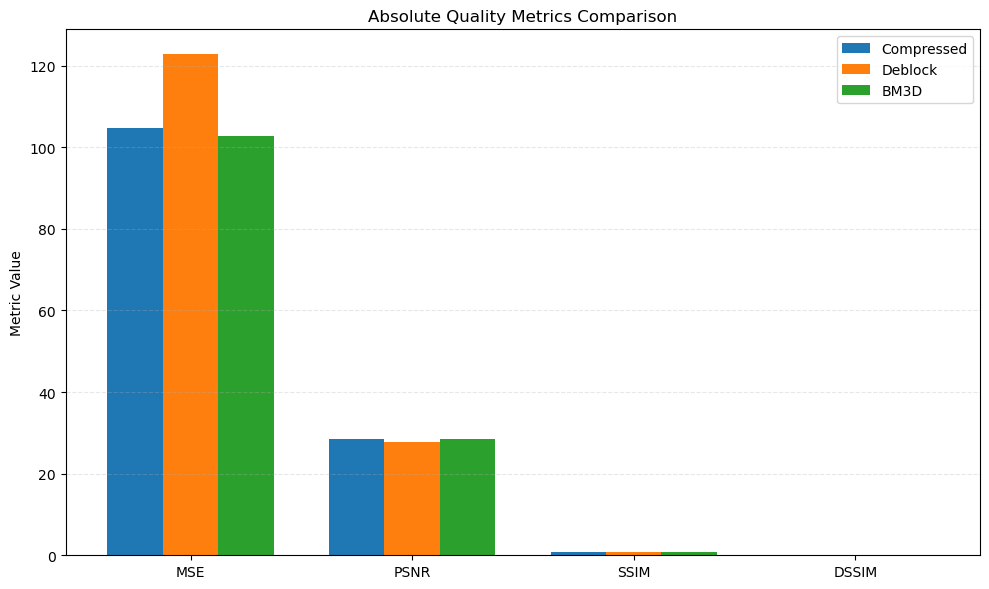

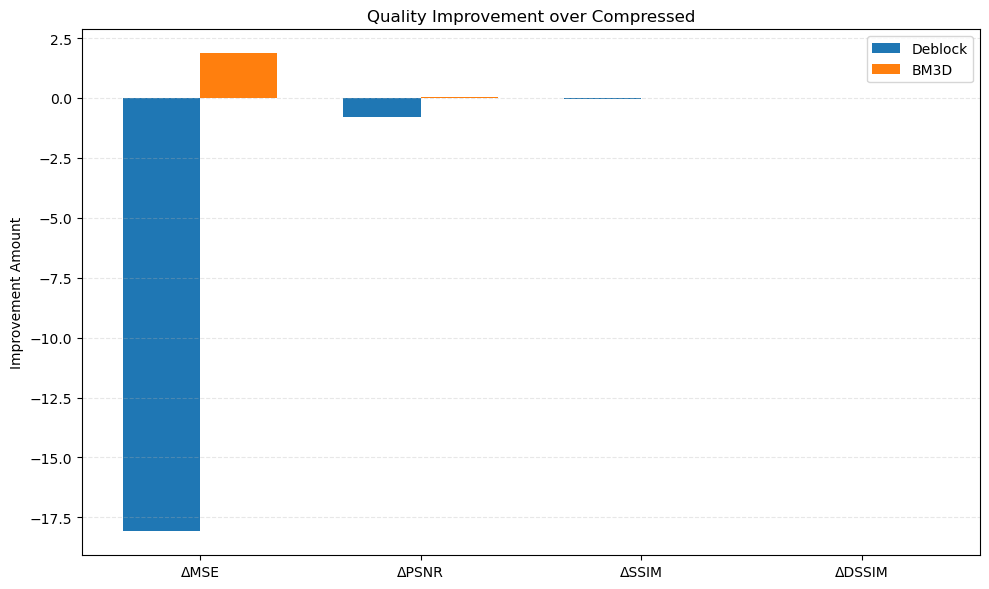

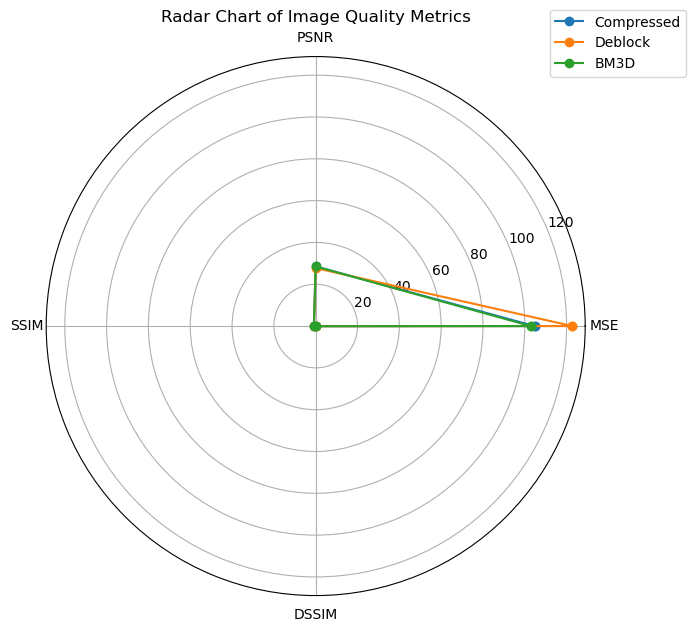

In [6]:
#   Compute Absolute Quality for each Method
def aggregate(result_dict):
    return {
        "MSE": np.mean([v["MSE"] for v in result_dict.values()]),
        "PSNR": np.mean([v["PSNR"] for v in result_dict.values()]),
        "SSIM": np.mean([v["SSIM"] for v in result_dict.values()]),
        "DSSIM": np.mean([v["DSSIM"] for v in result_dict.values()]),
    }

method_scores = {
    "Compressed": aggregate(compressed_results),
    "Deblock": aggregate(deblock_results),
    "BM3D": aggregate(bm3d_results),
}

print("\n=== method_scores (absolute values) ===")
print(method_scores)

#   Compute Improvement Over Compressed

improvement_scores = {}
for method in ["Deblock", "BM3D"]:
    improvement_scores[method] = {
        "ΔMSE": method_scores["Compressed"]["MSE"] - method_scores[method]["MSE"],
        "ΔPSNR": method_scores[method]["PSNR"] - method_scores["Compressed"]["PSNR"],
        "ΔSSIM": method_scores[method]["SSIM"] - method_scores["Compressed"]["SSIM"],
        "ΔDSSIM": method_scores["Compressed"]["DSSIM"] - method_scores[method]["DSSIM"],
    }

print("\n=== improvement_scores ===")
print(improvement_scores)

# Grouped Bar Chart

metrics = ["MSE", "PSNR", "SSIM", "DSSIM"]
methods = list(method_scores.keys())

values = np.array([[method_scores[m][metric] for metric in metrics]
                    for m in methods])

x = np.arange(len(metrics))
width = 0.25

plt.figure(figsize=(10,6))
for i, method in enumerate(methods):
    plt.bar(x + i*width, values[i], width, label=method)

plt.xticks(x + width, metrics)
plt.ylabel("Metric Value")
plt.title("Absolute Quality Metrics Comparison")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

# Improvement Chart

metrics_imp = ["ΔMSE", "ΔPSNR", "ΔSSIM", "ΔDSSIM"]
methods_imp = list(improvement_scores.keys())

values_imp = np.array([[improvement_scores[m][metric] for metric in metrics_imp] 
                        for m in methods_imp])

x = np.arange(len(metrics_imp))
width = 0.35

plt.figure(figsize=(10,6))
for i, method in enumerate(methods_imp):
    plt.bar(x + i*width, values_imp[i], width, label=method)

plt.xticks(x + width/2, metrics_imp)
plt.ylabel("Improvement Amount")
plt.title("Quality Improvement over Compressed")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Radar Chart
labels = np.array(metrics)
angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)
angles = np.concatenate((angles, [angles[0]]))

plt.figure(figsize=(7,7))
for method in methods:
    vals = np.array([method_scores[method][m] for m in metrics])
    vals = np.concatenate((vals, [vals[0]]))
    plt.polar(angles, vals, marker='o', label=method)

plt.xticks(angles[:-1], labels)
plt.title("Radar Chart of Image Quality Metrics")
plt.legend(loc='upper right', bbox_to_anchor=(1.2,1.1))
plt.show()



=== Absolute Method Scores ===
{'Compressed': {'MSE': 104.68725, 'PSNR': 28.504791911466572, 'SSIM': 0.866657037648737, 'DSSIM': 0.06667148117563147}, 'Deblock': {'MSE': 122.770905, 'PSNR': 27.72855383298651, 'SSIM': 0.8328683900951671, 'DSSIM': 0.08356580495241639}, 'BM3D': {'MSE': 102.82136, 'PSNR': 28.526488741106743, 'SSIM': 0.8638627326800231, 'DSSIM': 0.06806863365998844}}

=== Softmax Normalized Scores (0 < x < 1) ===
{'Compressed': {'MSE': 0.13401794182538168, 'PSNR': 0.40288990285380183, 'SSIM': 0.3373835771867874, 'DSSIM': 0.33536211673007804}, 'Deblock': {'MSE': 1.8772875306169843e-09, 'PSNR': 0.1853832404305894, 'SSIM': 0.3261742822893759, 'DSSIM': 0.32974399138747207}, 'BM3D': {'MSE': 0.8659820562973308, 'PSNR': 0.4117268567156089, 'SSIM': 0.33644214052383675, 'DSSIM': 0.3348938918824499}}


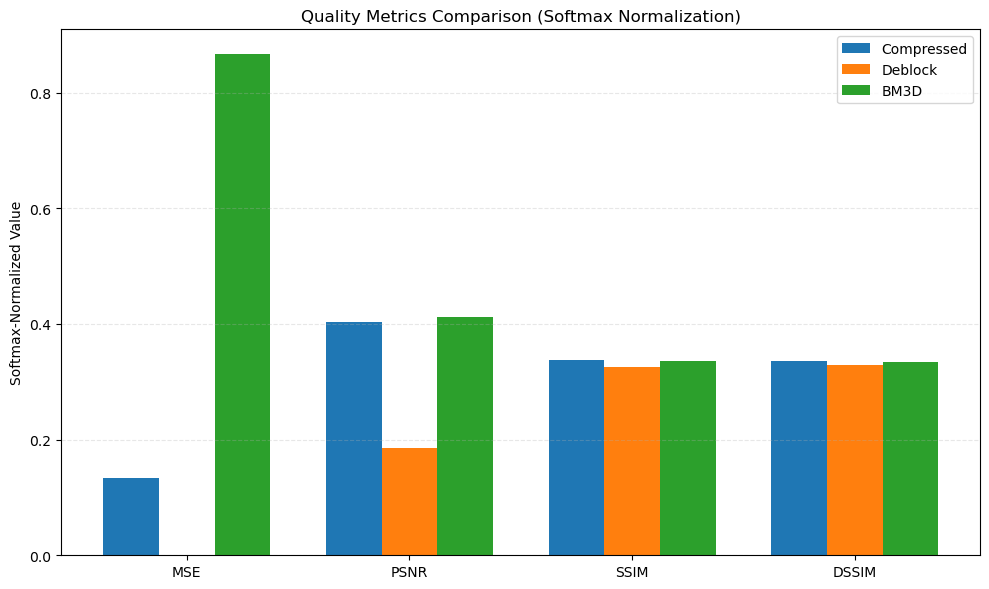

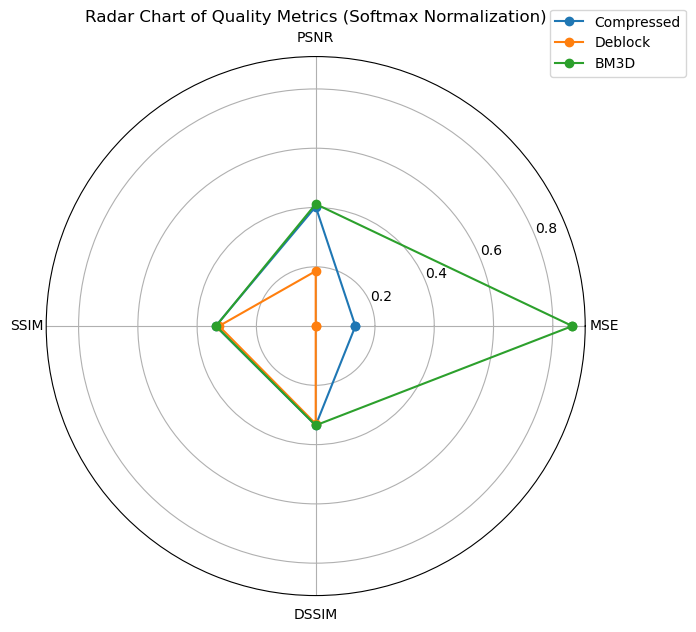


=== Softmax Normalized Improvements ===
{'Deblock': {'ΔMSE': -0.13401793994809416, 'ΔPSNR': -0.21750666242321243, 'ΔSSIM': -0.011209294897411515, 'ΔDSSIM': -0.005618125342605973}, 'BM3D': {'ΔMSE': 0.7319641144719491, 'ΔPSNR': 0.008836953861807051, 'ΔSSIM': -0.0009414366629506565, 'ΔDSSIM': -0.0004682248476281514}}


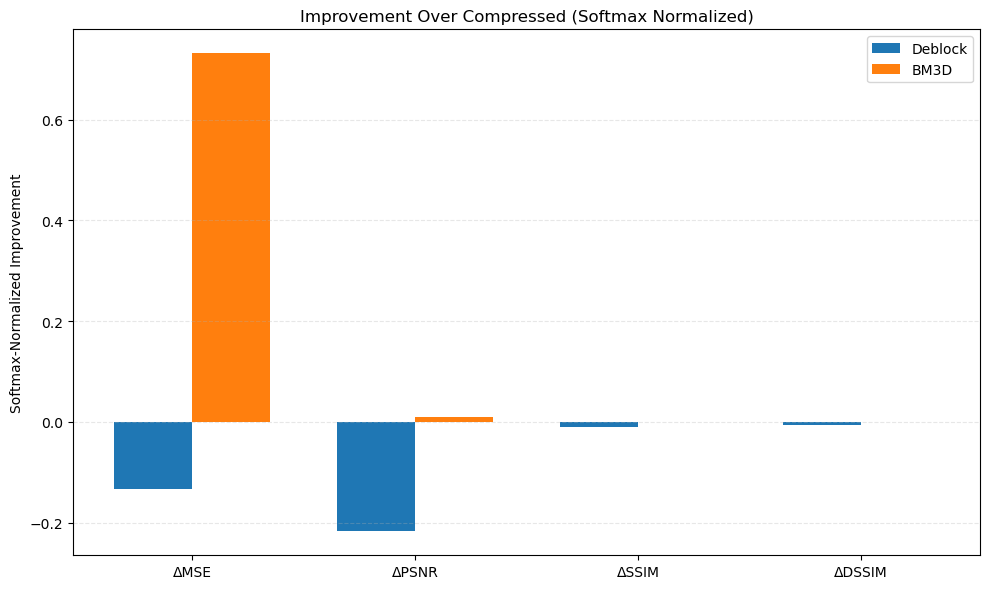

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# 1. Aggregate Absolute Method Scores
# ============================================================

def aggregate(result_dict):
    return {
        "MSE": np.mean([v["MSE"] for v in result_dict.values()]),
        "PSNR": np.mean([v["PSNR"] for v in result_dict.values()]),
        "SSIM": np.mean([v["SSIM"] for v in result_dict.values()]),
        "DSSIM": np.mean([v["DSSIM"] for v in result_dict.values()]),
    }

method_scores = {
    "Compressed": aggregate(compressed_results),
    "Deblock": aggregate(deblock_results),
    "BM3D": aggregate(bm3d_results),
}

metrics = ["MSE", "PSNR", "SSIM", "DSSIM"]
methods = list(method_scores.keys())

print("\n=== Absolute Method Scores ===")
print(method_scores)


# ============================================================
# 2. Softmax Normalization (Method 1)
# ============================================================

def normalize_softmax(col, lower_is_better=False):
    """
    Softmax normalization (ensures all values > 0),
    with correct handling for metrics where lower = better.
    """
    col = np.array(col, dtype=float)

    if lower_is_better:
        col = -col  # invert before softmax

    # numeric stability
    exp_vals = np.exp(col - np.max(col))
    return exp_vals / exp_vals.sum()


# Build softmax normalized score table
normalized_scores = {}

for metric in metrics:
    lower_is_better = (metric in ["MSE", "DSSIM"])

    col = [method_scores[method][metric] for method in methods]
    norm_col = normalize_softmax(col, lower_is_better)

    for i, method in enumerate(methods):
        if method not in normalized_scores:
            normalized_scores[method] = {}
        normalized_scores[method][metric] = norm_col[i]

print("\n=== Softmax Normalized Scores (0 < x < 1) ===")
print(normalized_scores)


# ============================================================
# 3. Normalized Grouped Bar Chart
# ============================================================

values = np.array([
    [normalized_scores[m][metric] for metric in metrics]
    for m in methods
])

x = np.arange(len(metrics))
width = 0.25

plt.figure(figsize=(10,6))
for i, method in enumerate(methods):
    plt.bar(x + i*width, values[i], width, label=method)

plt.xticks(x + width, metrics)
plt.ylabel("Softmax-Normalized Value")
plt.title("Quality Metrics Comparison (Softmax Normalization)")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


# ============================================================
# 4. Radar Chart (Softmax normalized)
# ============================================================

labels = np.array(metrics)
angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)
angles = np.concatenate((angles, [angles[0]]))

plt.figure(figsize=(7,7))
for method in methods:
    vals = np.array([normalized_scores[method][m] for m in metrics])
    vals = np.concatenate((vals, [vals[0]]))
    plt.polar(angles, vals, marker='o', label=method)

plt.xticks(angles[:-1], labels)
plt.title("Radar Chart of Quality Metrics (Softmax Normalization)")
plt.legend(loc='upper right', bbox_to_anchor=(1.2,1.1))
plt.show()


# ============================================================
# 5. Improvement over Compressed (Softmax Normalized)
# ============================================================

improvement_scores = {}

for method in ["Deblock", "BM3D"]:
    improvement_scores[method] = {
        f"Δ{metric}": normalized_scores[method][metric] - normalized_scores["Compressed"][metric]
        for metric in metrics
    }

print("\n=== Softmax Normalized Improvements ===")
print(improvement_scores)

metrics_imp = [f"Δ{m}" for m in metrics]
methods_imp = list(improvement_scores.keys())

values_imp = np.array([
    [improvement_scores[m][k] for k in metrics_imp]
    for m in methods_imp
])

x = np.arange(len(metrics_imp))
width = 0.35

plt.figure(figsize=(10,6))
for i, method in enumerate(methods_imp):
    plt.bar(x + i*width, values_imp[i], width, label=method)

plt.xticks(x + width/2, metrics_imp)
plt.ylabel("Softmax-Normalized Improvement")
plt.title("Improvement Over Compressed (Softmax Normalized)")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
# Mask Overlap (IoU)
# Original videos' mask is considered as ground-truth

def mask_iou(mask1, mask2):
    mask1 = mask1 > 127
    mask2 = mask2 > 127
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    return intersection / union if union > 0 else 0

def evaluate_mask_iou(gt_folder, pred_folder):
    ious = []

    for sub in sorted(os.listdir(gt_folder)):
        if sub.startswith('.'):
            continue

        sub_gt = os.path.join(gt_folder, sub)
        sub_pd = os.path.join(pred_folder, sub)

        if not os.path.isdir(sub_gt) or not os.path.isdir(sub_pd):
            continue

        for fname in sorted(os.listdir(sub_gt)):
            path_gt = os.path.join(sub_gt, fname)
            path_pd = os.path.join(sub_pd, fname)

            gt = cv2.imread(path_gt, 0)
            pd = cv2.imread(path_pd, 0)

            if gt is None or pd is None:
                print("WARNING missing:", path_gt, path_pd)
                continue

            ious.append(mask_iou(gt, pd))

    return np.mean(ious)

# Example usage
print("Mask IoU (Compressed):", evaluate_mask_iou(MASK_ORIG, MASK_COMP))
print("Mask IoU (Deblock):", evaluate_mask_iou(MASK_ORIG, MASK_DEBLOCK))
print("Mask IoU (BM3D):", evaluate_mask_iou(MASK_ORIG, MASK_BM3D))
# print("Mask IoU (Combo):", evaluate_mask_iou(MASK_ORIG, MASK_COMBO))

def mask_metrics(gt, pred):
    gt_bool = gt > 0
    pred_bool = pred > 0

    tp = np.logical_and(gt_bool, pred_bool).sum()
    fp = np.logical_and(~gt_bool, pred_bool).sum()
    fn = np.logical_and(gt_bool, ~pred_bool).sum()
    tn = np.logical_and(~gt_bool, ~pred_bool).sum()

    iou = tp / (tp + fp + fn + 1e-8)
    dice = 2 * tp / (2 * tp + fp + fn + 1e-8)
    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    pixel_acc = (tp + tn) / (tp + fp + fn + tn + 1e-8)

    return {
        "IoU": iou,
        "Dice": dice,
        "Precision": precision,
        "Recall": recall,
        "PixelAcc": pixel_acc,
    }

def evaluate_mask_folder(gt_root, pred_root):
    results = {}

    for folder in sorted(os.listdir(gt_root)):
        if folder.startswith('.'):
            continue

        gt_path = os.path.join(gt_root, folder)
        pred_path = os.path.join(pred_root, folder)

        if not (os.path.isdir(gt_path) and os.path.isdir(pred_path)):
            continue

        iou_list, dice_list, prec_list, rec_list, acc_list = [], [], [], [], []

        files = sorted([f for f in os.listdir(gt_path) if f.endswith(".png")])
        # print("Evaluating mask folder:", folder)

        for fname in files:
            gt_img = cv2.imread(os.path.join(gt_path, fname), cv2.IMREAD_GRAYSCALE)
            pred_img = cv2.imread(os.path.join(pred_path, fname), cv2.IMREAD_GRAYSCALE)

            if gt_img is None or pred_img is None:
                print("WARNING: failed to load mask:", fname)
                continue

            m = mask_metrics(gt_img, pred_img)
            iou_list.append(m["IoU"])
            dice_list.append(m["Dice"])
            prec_list.append(m["Precision"])
            rec_list.append(m["Recall"])
            acc_list.append(m["PixelAcc"])

        results[folder] = {
            "IoU": np.mean(iou_list),
            "Dice": np.mean(dice_list),
            "Precision": np.mean(prec_list),
            "Recall": np.mean(rec_list),
            "PixelAcc": np.mean(acc_list),
        }

    return results

mask_comp_results    = evaluate_mask_folder(MASK_ORIG, MASK_COMP)
mask_deblock_results = evaluate_mask_folder(MASK_ORIG, MASK_DEBLOCK)
mask_bm3d_results    = evaluate_mask_folder(MASK_ORIG, MASK_BM3D)

In [16]:
def aggregate_mask_results(results):
    return {
        "IoU": np.mean([v["IoU"] for v in results.values()]),
        "Dice": np.mean([v["Dice"] for v in results.values()]),
        "Precision": np.mean([v["Precision"] for v in results.values()]),
        "Recall": np.mean([v["Recall"] for v in results.values()]),
        "PixelAcc": np.mean([v["PixelAcc"] for v in results.values()]),
    }

avg_comp    = aggregate_mask_results(mask_comp_results)
avg_deblock = aggregate_mask_results(mask_deblock_results)
avg_bm3d    = aggregate_mask_results(mask_bm3d_results)

print("\n=== Average Mask Metrics Across All Videos ===")
print("Compressed:", avg_comp)
print("Deblock:", avg_deblock)
print("BM3D:", avg_bm3d)



=== Average Mask Metrics Across All Videos ===
Compressed: {'IoU': 0.6663462422039086, 'Dice': 0.76002394182022, 'Precision': 0.6856879180913339, 'Recall': 0.8827794600715864, 'PixelAcc': 0.9220298437494372}
Deblock: {'IoU': 0.7154427699361434, 'Dice': 0.7864046631338024, 'Precision': 0.8537198483009507, 'Recall': 0.748512650214083, 'PixelAcc': 0.9554750390619167}
BM3D: {'IoU': 0.7672158074122274, 'Dice': 0.823605088645748, 'Precision': 0.8381896386410108, 'Recall': 0.8230334347814932, 'PixelAcc': 0.9671110131830034}


In [ ]:
import os
import cv2
import imageio
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
sys.path.append("../Video_Decaptioning/video_decaption")
from dataset.dataset import *
from model.network import generator
from torchvision import transforms

# =====================
# Configuration
# =====================
BASE = "./"

FRAME_ROOT = os.path.join(BASE, "frame_{}")      # frame_compressed, frame_deblock, frame_bm3d
MASK_ROOT  = os.path.join(BASE, "mask_{}")       # mask_comp, mask_deblock, mask_bm3d
OUTPUT_ROOT = os.path.join(BASE, "results/recovered_{}")


METHODS = {
      "raw": ("raw", "orig"),
#     "compressed": ("compressed", "comp"),
#     "deblock": ("deblock", "deblock"),
#     "bm3d": ("bm3d", "bm3d"),
}

n_frames = 125
model_G_path = '../Video_Decaptioning/video_decaption/checkpoint/netG.pth'
T = 7
s = 3

# # Output folders
# OUT_COMP   = "./recovered_compressed"
# OUT_DEBLOCK = "./recovered_deblock"
# OUT_BM3D    = "./recovered_bm3d"

# for d in [OUT_COMP, OUT_DEBLOCK, OUT_BM3D]:
#     os.makedirs(d, exist_ok=True)
#     os.makedirs(os.path.join(d, "frames"), exist_ok=True)

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

net_G = generator()
net_G.load_state_dict(torch.load(model_G_path))
net_G = net_G.cuda()
net_G = torch.nn.DataParallel(net_G, device_ids=[0])
net_G.eval()

def recover_video(method_key, frames_dir, masks_dir, out_dir):

    print(f"\n=== Recovering: {method_key} | {frames_dir} ===")

    os.makedirs(os.path.join(out_dir, "frames"), exist_ok=True)

    # list all frames: 000.png, 001.png, 002.png, ...
    files = sorted([f for f in os.listdir(frames_dir) if f.endswith(".png")])
    n_frames = len(files)

    frames_np = np.empty((n_frames, 128, 128, 3), dtype=np.float32)
    masks_np  = np.empty((n_frames, 1,   128, 128), dtype=np.float32)

    # Read frames + masks
    for i, fname in enumerate(files):
        frame_img = np.array(Image.open(os.path.join(frames_dir, fname)).convert("RGB")) / 255.0
        frames_np[i] = frame_img

        mask_img = cv2.imread(os.path.join(masks_dir, fname), 0)
        masks_np[i, 0] = (mask_img > 127).astype(np.float32)

    # Convert to tensor and normalize
    frames = torch.from_numpy(frames_np.transpose(0, 3, 1, 2)).float().cuda()
    frames = (frames - 0.5) / 0.5
    frames = frames.unsqueeze(0)

    masks = torch.from_numpy(masks_np).float().cuda()
    masks = masks.unsqueeze(0)

    # Temporal padding
    frames_pad = videopadding(frames, s, T)
    masks_pad  = videopadding(masks,  s, T)

    recovered_frames = []

    # Run generator
    with torch.no_grad():
        for j, fname in enumerate(files):

            imgs = frames_pad[:, j : j + (T - 1) * s + 1 : s]
            msks = masks_pad[:,  j : j + (T - 1) * s + 1 : s]

            pred = net_G(imgs, msks)
            pred = (pred * 0.5 + 0.5).clamp(0, 1)

            arr = pred.squeeze(0).cpu().numpy().transpose(1, 2, 0)
            arr = (arr * 255).astype(np.uint8)

            # save frame
            cv2.imwrite(
                os.path.join(out_dir, "frames", fname),
                cv2.cvtColor(arr, cv2.COLOR_RGB2BGR),
            )

            recovered_frames.append(arr)

    # save mp4
    video_path = os.path.join(out_dir, "recovered.mp4")
    imageio.mimwrite(video_path, recovered_frames, fps=25, quality=8, macro_block_size=1)

    print("Saved:", video_path)

# ========================== Loop through all videos ==========================
for method_key, (frame_suffix, mask_suffix) in METHODS.items():

    FRAME_DIR = FRAME_ROOT.format(frame_suffix)
    MASK_DIR  = MASK_ROOT.format(mask_suffix)
    OUT_DIR_ROOT = OUTPUT_ROOT.format(frame_suffix)

    print(f"\n### METHOD = {method_key}")
    print("Frame directory:", FRAME_DIR)
    print("Mask directory:", MASK_DIR)

    video_folders = sorted([
    d for d in os.listdir(FRAME_DIR)
    if os.path.isdir(os.path.join(FRAME_DIR, d))
    and not d.startswith('.')
])

    for video_name in video_folders:
        print("Processing video:", video_name)

        frames_dir = os.path.join(FRAME_DIR, video_name)
        masks_dir  = os.path.join(MASK_DIR,  video_name)
        out_dir    = os.path.join(OUT_DIR_ROOT, video_name)

        recover_video(method_key, frames_dir, masks_dir, out_dir)

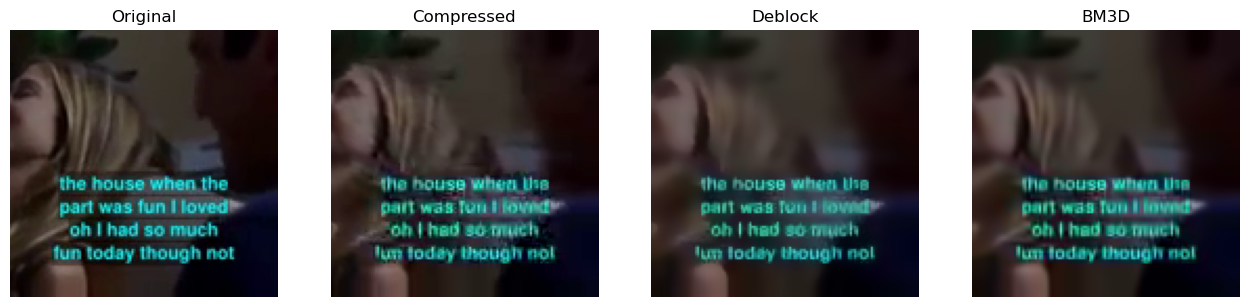

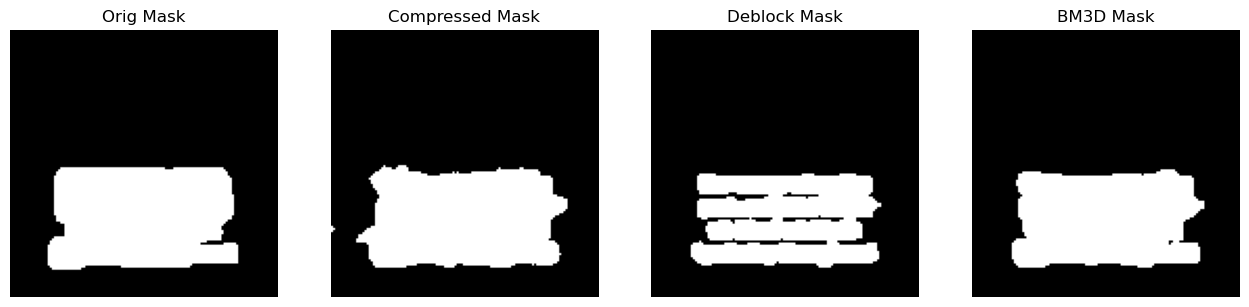

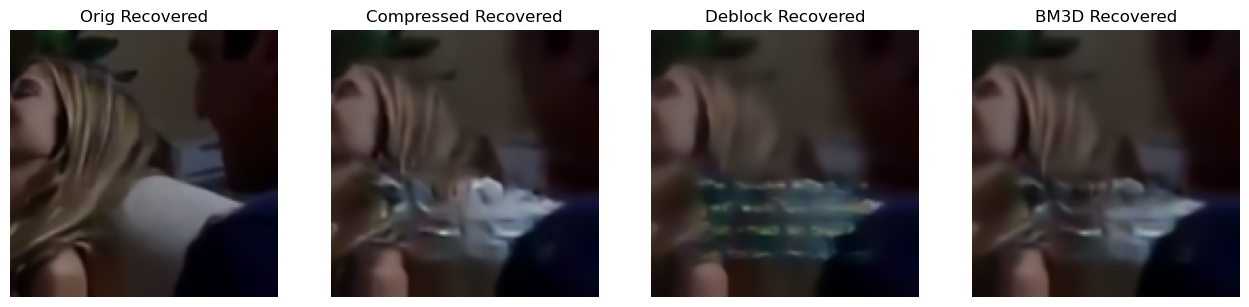

In [29]:
# Visualization
RECOVERED_RAW    = "results/recovered_raw"
RECOVERED_COMP    = "results/recovered_compressed"
RECOVERED_DEBLOCK = "results/recovered_deblock"
RECOVERED_BM3D    = "results/recovered_bm3d"

def show_compare(folder, fname):
    paths = [
        os.path.join(OUTPUT_RAW_FRAMES, folder, fname),
        os.path.join(OUTPUT_COMPRESSED_FRAMES, folder, fname),
        os.path.join(FRAMES_DEBLOCK, folder, fname),
        os.path.join(FRAMES_BM3D, folder, fname),
        # os.path.join(FRAMES_COMBO, folder, fname),
    ]

    imgs = [cv2.imread(p) for p in paths]
    titles = ["Original", "Compressed", "Deblock", "BM3D"]

    plt.figure(figsize=(20, 5))
    for i, (img, t) in enumerate(zip(imgs, titles)):
        plt.subplot(1, 5, i+1)
        if img is None:
            plt.title(f"{t}\n[MISSING]")
        else:
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.title(t)
        plt.axis("off")

def show_mask_compare(folder, fname):
    m_o  = cv2.imread(f"{MASK_ORIG}/{folder}/{fname}",  0)
    m_c  = cv2.imread(f"{MASK_COMP}/{folder}/{fname}",  0)
    m_d  = cv2.imread(f"{MASK_DEBLOCK}/{folder}/{fname}", 0)
    m_b  = cv2.imread(f"{MASK_BM3D}/{folder}/{fname}",   0)
    # m_cb = cv2.imread(f"{MASK_COMBO}/{folder}/{fname}",  0)

    masks = [m_o, m_c, m_d, m_b]
    titles = ["Orig Mask", "Compressed Mask", "Deblock Mask", "BM3D Mask"]

    plt.figure(figsize=(20, 5))
    for i, (m, t) in enumerate(zip(masks, titles)):
        plt.subplot(1, 5, i+1)
        plt.imshow(m, cmap="gray")
        plt.title(t)
        plt.axis("off")

def show_recovery_compare(folder, fname):
    paths = [
        os.path.join(RECOVERED_RAW, folder, fname),
        os.path.join(RECOVERED_COMP, folder, fname),
        os.path.join(RECOVERED_DEBLOCK, folder, fname),
        os.path.join(RECOVERED_BM3D, folder, fname),
    ]

    imgs = [cv2.imread(p) for p in paths]
    titles = ["Orig Recovered", "Compressed Recovered", "Deblock Recovered", "BM3D Recovered"]

    plt.figure(figsize=(20, 5))
    for i, (img, t) in enumerate(zip(imgs, titles)):
        plt.subplot(1, 5, i+1)
        if img is None:
            plt.title(f"{t}\n[MISSING]")
        else:
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.title(t)
        plt.axis("off")
        
# Example:
show_compare("X10056", "105.png")
show_mask_compare("X10056", "105.png")
show_recovery_compare("X10056/frames", "105.png")